# Convolutions-Vision-Transformers

Implementation of [CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)

![Pipeline](figures/pipeline.svg)

Dataset used: [Tom and Jerry Image classification | Kaggle](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification)



University of Rome, La Sapienza. Artificial Intelligence and Robotics. Neural Networks Course A.Y. 2022/23

Esteban Vincent | Aurélien Lurois

In [12]:
#!pip install -q -r requirements.txt 

In [13]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
#archive.zip is an archive containing the folders 'cvt' and 'dataset'
#!gdown 1lCZsvDagoACJvA1XdP02K3PaKT-Or19m
#!unzip archive

In [15]:
#!gdown 1D3bogzPcdxWsQkL94Tgx30D-YrTE5dFB
#!unzip archive224

In [16]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from cvt.cvt import CvT
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CvT(128, 3, 4).to(device)

df = pd.read_csv("dataset/ground_truth.csv")
df = df[["filename", "class"]]

train_df, test_df = train_test_split(df, test_size=0.2)

In [18]:
class FrameDataset(Dataset):
    def __init__(self, df):
        self.filenames = df["filename"].tolist()
        self.images = []
        self.labels = df["class"].tolist()

        for filename in tqdm(self.filenames):
            img = Image.open(f"dataset/imgs/{filename}")
            # Convert the image to a PyTorch tensor
            img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1)
            # Normalize the tensor by dividing by 255
            img_tensor = img_tensor.float() / 255
            self.images.append(img_tensor)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx])

In [31]:
train_loader = DataLoader(FrameDataset(train_df), batch_size=64, shuffle=True)

# Define the loss function
loss_fun = nn.CrossEntropyLoss()

# Choose an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.02)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

100%|██████████| 4382/4382 [00:02<00:00, 1831.92it/s]


In [44]:
#@title Train the model
model.train()
for epoch in tqdm(range(100), desc="Epochs", position=1, leave=False):
    running_loss = 0.0
    for image, label in tqdm(train_loader, desc="Images", position=0, leave=False):
        optimizer.zero_grad()

        output = model(image.to(device))
        loss = loss_fun(output, label.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f' Epoch {epoch+1} training loss: {running_loss/len(train_loader):.3f}')

Epochs:   1%|          | 1/100 [00:26<44:04, 26.71s/it]

 Epoch 1 training loss: 0.873


Epochs:   2%|▏         | 2/100 [00:52<42:49, 26.22s/it]

 Epoch 2 training loss: 0.865


Epochs:   3%|▎         | 3/100 [01:18<42:02, 26.00s/it]

 Epoch 3 training loss: 0.867


Epochs:   4%|▍         | 4/100 [01:44<41:53, 26.18s/it]

 Epoch 4 training loss: 0.883


Epochs:   5%|▌         | 5/100 [02:10<41:18, 26.08s/it]

 Epoch 5 training loss: 0.889


Epochs:   6%|▌         | 6/100 [02:36<40:45, 26.02s/it]

 Epoch 6 training loss: 0.890


Epochs:   7%|▋         | 7/100 [03:02<40:17, 26.00s/it]

 Epoch 7 training loss: 0.888


KeyboardInterrupt: ignored

In [41]:
torch.save(model, 'model.pt')

Validation: 100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


Accuracy of the model on the validation images: 74.82%


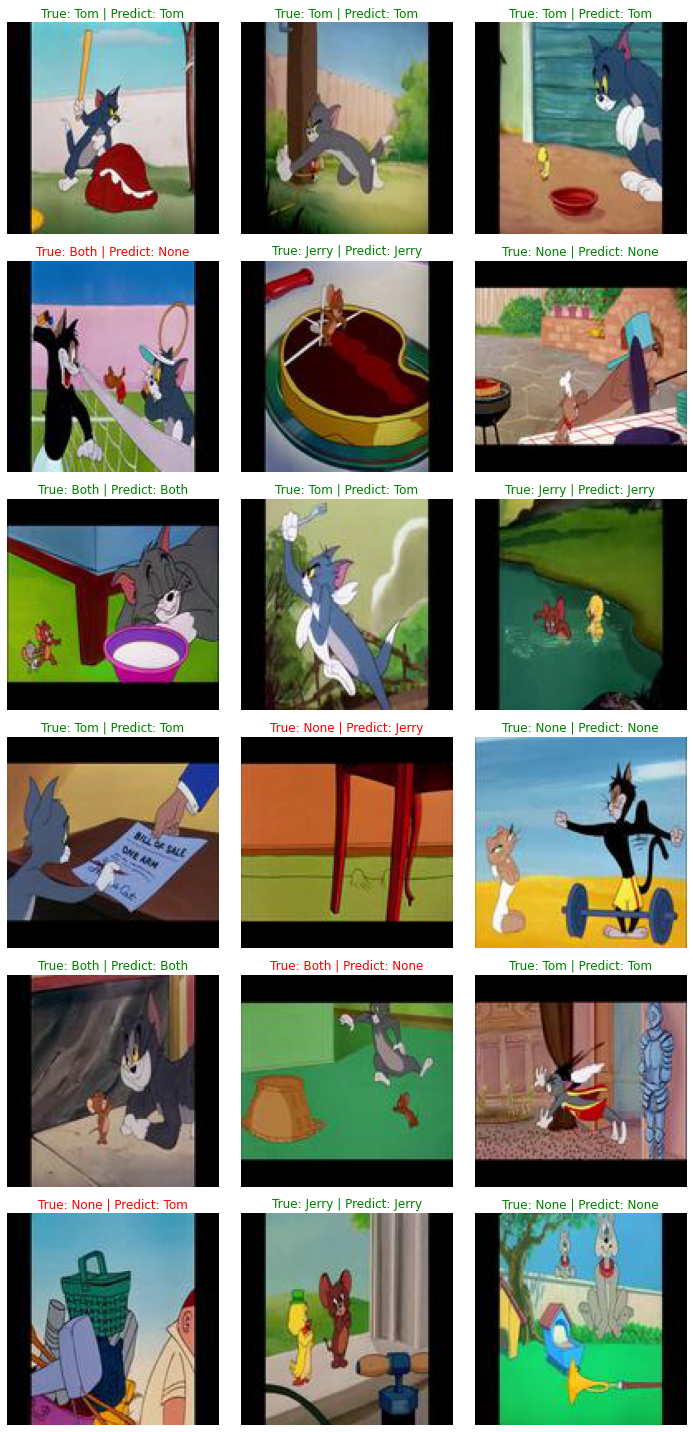

In [71]:
test_loader = DataLoader(FrameDataset(test_df), batch_size=64, shuffle=False)

model.eval()
correct = 0
total = 0
label_name = ['None', 'Jerry', 'Tom', 'Both']
i = 0 

fig, axs = plt.subplots(6, 3, figsize=(10, 20))
axs = axs.ravel()

with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Validation", position=0, leave=True):
        output = model(image.to(device))
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label.to(device)).sum().item()


        axs[i].imshow(np.transpose(image[0], (1, 2, 0)))
        axs[i].set_title("True: %s | Predict: %s" % (label_name[label[0].item()], label_name[predicted[0].item()]),
                 color=("green" if label[0] == predicted[0] else "red"))

        axs[i].axis("off")
        i +=1

print(f'Accuracy of the model on the validation images: {100 * correct / total:.2f}%')

plt.tight_layout()
plt.show()